# Model Analysis
This notebook trains a machine learning model to predict LaLiga match outcomes. The model classifies each match as:
- **1**: Home team wins
- **2**: Away team wins
- **0**: Draw


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the two tables from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()


final_result = pd.read_csv('../reports/MatchdayStandings.csv')
df_matches_original = df_matches.copy()

### clean dataset

In [3]:
def seasons(arg_season_train):
    start, end = map(int, arg_season_train.split(':'))
    return [f'{year}-{year + 1}' for year in range(start, end + 1)]

arg_seasons_train = '2010:2020'
arg_season_pred = '2021-2022'
arg_division_pred = 1
arg_matchday_pred = 3

seasons_train = seasons(arg_seasons_train) #List with seasons

In [4]:
def count_points(last_5):
    if type(last_5) is int:
        return last_5

    if last_5 == 0:
        return 0
        
    count = 0
    for i in last_5:
        if i == 'W':
            count += 3
        elif i == 'T':
            count += 1
    return count

In [5]:
def df_model(df,final_result,seasons_train,arg_division_pred):
    
    df = df.drop(columns=['time', 'date'])
    
    # creating two new columns, one for the score of the home team, and one for the score of the away team
    df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True).astype(float)
    
    # creating one new column to show which team won (1 for home team, 2 for away team), or if it was a tie (X)
    df['winner'] = df.apply(lambda row: 
                                            np.nan if pd.isna(row['home_score']) or pd.isna(row['away_score'])
                                            else 1 if row['home_score'] > row['away_score']
                                            else 2 if row['home_score'] < row['away_score']
                                            else 0, axis=1)
    
    #df = df.astype('category')
    
    df.dropna(inplace=True)
    df = df[(df['season'].isin(seasons_train))&(df['division']==arg_division_pred)]
    df = df[['season','division','matchday','home_team','away_team','home_score','away_score','winner']].dropna()
    df['home_score'] = df['home_score'].astype(int)
    df['away_score'] = df['away_score'].astype(int)
    
    final_result_home = final_result.rename(columns={'team':'home_team'})
    final_result_away = final_result.rename(columns={'team':'away_team'})
    
    # Determine the last matchday per season and division in final_result
    last_matchday_per_season = final_result.groupby(['season', 'division'])['matchday'].max().reset_index()
    last_matchday_per_season = last_matchday_per_season.rename(columns={'matchday': 'last_matchday'})
    last_matchday_per_season
    # Merge this information into df to determine which matchday data to pull
    df = df.merge(last_matchday_per_season, on=['season', 'division'], how='left')
    
    # Create columns for the correct `matchday` to look up in `final_result`:
    # If matchday is 1, use the last matchday from the previous season; otherwise, use `matchday - 1`
    df['lookup_matchday'] = df.apply(lambda row: row['last_matchday'] if row['matchday'] == 1 else row['matchday'] - 1, axis=1)
    
    # For merging purposes, add one more step to handle cases for the previous season if matchday is 1
    df['lookup_season'] = df.apply(
        lambda row: str(int(row['season'].split('-')[0]) - 1) + '-' + str(int(row['season'].split('-')[1]) - 1) 
        if row['matchday'] == 1 else row['season'],
        axis=1
    )
    
    merged_df = df.merge(final_result_home, left_on=['lookup_season', 'division', 'lookup_matchday', 'home_team'],
                                                    right_on=['season', 'division', 'matchday', 'home_team'], how='left')
    merged_df = merged_df.merge(final_result_away, left_on=['lookup_season', 'division', 'lookup_matchday', 'away_team'],
                                                   right_on=['season', 'division', 'matchday', 'away_team'], how='left', suffixes=('_home', '_away'))
    df_final = merged_df.drop(columns=['lookup_matchday', 'lookup_season', 'last_matchday', 'season_y', 'matchday_y', 'season', 'matchday'])
    
    #df_final['winner'] = df_final['winner'].astype('category')
    #df_final['division'] = df_final['division'].astype('category')
    
    columns_to_fill = [
        'GF_home', 'GA_home', 'GD_home', 'W_home', 'L_home', 'T_home', 'Pts_home', 'rank_home', 'result_home', 'last_5_home',
        'GF_away', 'GA_away', 'GD_away', 'W_away', 'L_away', 'T_away', 'Pts_away', 'rank_away', 'result_away', 'last_5_away'
    ]
    df_final[columns_to_fill] = df_final[columns_to_fill]
    
    df_final = df_final.dropna().reset_index(drop=True)
    
    df_final['GF_home_avg'] = df_final['GF_home'] / df_final['matchday_x']
    df_final['GA_home_avg'] = df_final['GA_home'] / df_final['matchday_x']
    df_final['GF_away_avg'] = df_final['GF_away'] / df_final['matchday_x']
    df_final['GA_away_avg'] = df_final['GA_away'] / df_final['matchday_x']
    
    df_final['GDD'] = (df_final['GD_home'] - df_final['GD_away']) / df_final['matchday_x']
    df_final['rank_diff'] = df_final['rank_home'] - df_final['rank_away']
    df_final['GFH_GAA'] = (df_final['GF_home'] - df_final['GA_away']) / df_final['matchday_x']
    df_final['GFA_GAH'] = (df_final['GF_away'] - df_final['GA_home']) / df_final['matchday_x']
    df_final['GDH_GDA'] = (df_final['GFH_GAA'] - df_final['GFA_GAH']) / df_final['matchday_x']
    
    df_final['last_5_home'] = df_final['last_5_home'].apply(lambda x: count_points(x))
    df_final['last_5_away'] = df_final['last_5_away'].apply(lambda x: count_points(x))
    
    df_final['last_5_diff'] = df_final['last_5_home'] - df_final['last_5_away']
    
    return df_final

In [6]:
df_balanced = df_model(df_matches,final_result,seasons_train,arg_division_pred)
minority_cat = min(df_balanced['winner'].value_counts()) 

df_balanced = pd.concat([
    df_balanced[df_balanced['winner'] == 0].sample(minority_cat, random_state=42),
    df_balanced[df_balanced['winner'] == 1].sample(minority_cat, random_state=42),
    df_balanced[df_balanced['winner'] == 2].sample(minority_cat, random_state=42)
]).reset_index(drop=True)

In [7]:
target = 'winner'
features = ['GDD','rank_home','rank_away','rank_diff','GD_home','GD_away','last_5_diff']#, 'home_score', 'away_score']
X, y = df_balanced[features], df_balanced[target]

Accuracy GaussianNB: 0.46
Classification Report:
               precision    recall  f1-score   support

         0.0       0.39      0.41      0.40       207
         1.0       0.50      0.46      0.48       210
         2.0       0.49      0.52      0.51       192

    accuracy                           0.46       609
   macro avg       0.46      0.46      0.46       609
weighted avg       0.46      0.46      0.46       609



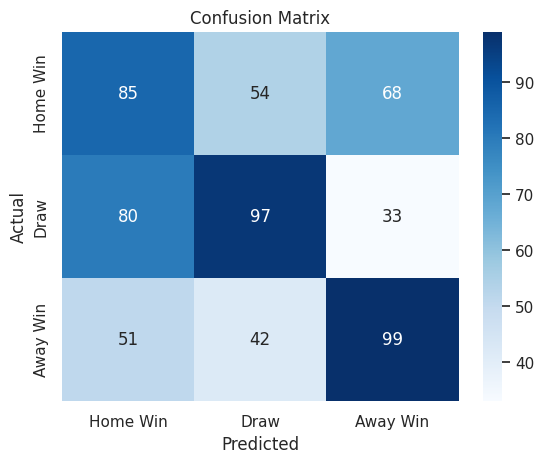

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

# Accuracy score
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy GaussianNB: {accuracy_gnb:.2f}')

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_gnb))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

         0.0       0.41      0.42      0.41       207
         1.0       0.51      0.51      0.51       210
         2.0       0.52      0.50      0.51       192

    accuracy                           0.48       609
   macro avg       0.48      0.48      0.48       609
weighted avg       0.48      0.48      0.48       609

Accuracy: 0.48
Classification Report:
               precision    recall  f1-score   support

         0.0       0.41      0.42      0.41       207
         1.0       0.51      0.51      0.51       210
         2.0       0.52      0.50      0.51       192

    accuracy                           0.48       609
   macro avg       0.48      0.48      0.48       609
weighted avg       0.48      0.48      0.48       609



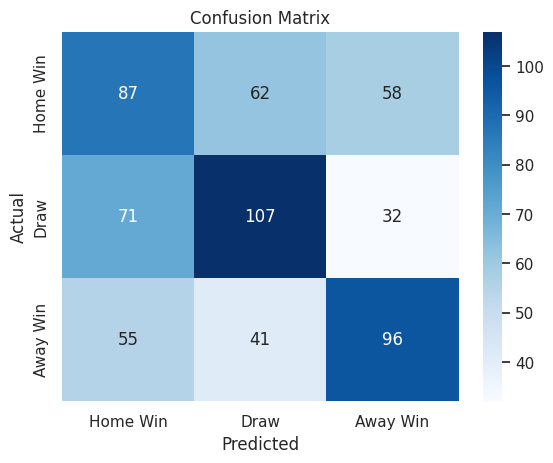

In [9]:
# Supongamos que tu DataFrame se llama `df`
# Asegúrate de que "winner" sea una variable categórica (por ejemplo, 0, 1, 2 para perder, ganar, empate)
#df_final['winner_cat'] = df['winner'].astype('category')

# Seleccionar las variables que quieres usar como características
features = ['GDD','rank_home','rank_away','rank_diff','GD_home','GD_away','last_5_diff']

# Separar X y y de nuevo
X_train_balanced = df_balanced.drop('winner', axis=1)[features]
y_train_balanced = df_balanced['winner']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=1)

# Crear el modelo
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
rf_y_pred = model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = rf_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,GDD,rank_home,rank_away,rank_diff,GD_home,GD_away,last_5_diff,y_real,y_pred,err,%_err
6,-0.125000,13.0,6.0,7.0,4.0,6.0,-5,0.0,2,-2.0,-inf
1403,1.846154,1.0,18.0,-17.0,15.0,-9.0,7,1.0,1,0.0,0.0
1330,0.925926,2.0,11.0,-9.0,21.0,-4.0,-1,1.0,1,0.0,0.0
2968,-1.000000,16.0,5.0,11.0,-8.0,4.0,-5,2.0,2,0.0,0.0
2274,0.040000,7.0,10.0,-3.0,1.0,0.0,-3,2.0,1,1.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...
2282,-0.846154,4.0,2.0,2.0,13.0,24.0,-2,2.0,2,0.0,0.0
2680,1.000000,2.0,10.0,-8.0,20.0,-1.0,3,2.0,1,1.0,50.0
236,-0.533333,19.0,14.0,5.0,-10.0,-2.0,-3,0.0,0,0.0,NaN
854,0.588235,14.0,18.0,-4.0,-13.0,-33.0,-2,0.0,0,0.0,NaN


In [11]:
print(f"RMSE: {mean_squared_error(y_test, rf_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_y_pred)}")

RMSE: 1.039451668003348
MAPE: 1316323043796302.5
R^2: -0.6506512444081956


In [12]:
df_pred = df_matches[(df_matches['season']==arg_season_pred)&(df_matches['division']==arg_division_pred)&(df_matches['matchday']==arg_matchday_pred)].reset_index(drop=True)
df_pred

,season,division,matchday,date,time,home_team,away_team,score
0,2021-2022,1,3,8/27/21,8:00 PM,RCD Mallorca,Espanyol,1:0
1,2021-2022,1,3,8/27/21,10:15 PM,Valencia,Alavés,3:0
2,2021-2022,1,3,8/28/21,5:00 PM,Celta de Vigo,Athletic,0:1
3,2021-2022,1,3,8/28/21,7:30 PM,Real Sociedad,Levante,1:0
4,2021-2022,1,3,8/28/21,7:30 PM,Elche CF,Sevilla FC,1:1
5,2021-2022,1,3,8/28/21,10:00 PM,Real Betis,Real Madrid,0:1
6,2021-2022,1,3,8/29/21,5:00 PM,Barcelona,Getafe,2:1
7,2021-2022,1,3,8/29/21,7:30 PM,Cádiz CF,CA Osasuna,2:3
8,2021-2022,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0
9,2021-2022,1,3,8/29/21,10:00 PM,Atlético Madrid,Villarreal,2:2


In [13]:
predictions = model.predict(df_model(df_pred,final_result,[arg_season_pred],arg_division_pred)[features])

print("For Random Forest Classifier model:")
print(f"Matchday {arg_matchday_pred} - LaLiga - Division {arg_division_pred} - Season {arg_season_pred}")
print("=" * 70)
for index, row in df_pred.iterrows():
    print(f"{row['home_team']:^30s} vs {row['away_team']:^30s} --> {predictions[index]}")

For Random Forest Classifier model:
Matchday 3 - LaLiga - Division 1 - Season 2021-2022
         RCD Mallorca          vs            Espanyol            --> 1.0
           Valencia            vs             Alavés             --> 1.0
        Celta de Vigo          vs            Athletic            --> 0.0
        Real Sociedad          vs            Levante             --> 0.0
           Elche CF            vs           Sevilla FC           --> 2.0
          Real Betis           vs          Real Madrid           --> 2.0
          Barcelona            vs             Getafe             --> 1.0
           Cádiz CF            vs           CA Osasuna           --> 0.0
        Rayo Vallecano         vs           Granada CF           --> 0.0
       Atlético Madrid         vs           Villarreal           --> 1.0


In [14]:
pred_gnb = gnb.fit(X_train, y_train).predict(df_model(df_pred,final_result,[arg_season_pred],arg_division_pred)[features])
print("For Gaussian Naive Bayes model:")
print(f"Matchday {arg_matchday_pred} - LaLiga - Division {arg_division_pred} - Season {arg_season_pred}")
print("=" * 70)
for index, row in df_pred.iterrows():
    print(f"{row['home_team']:^30s} vs {row['away_team']:^30s} --> {pred_gnb[index]}")

For Gaussian Naive Bayes model:
Matchday 3 - LaLiga - Division 1 - Season 2021-2022
         RCD Mallorca          vs            Espanyol            --> 1.0
           Valencia            vs             Alavés             --> 1.0
        Celta de Vigo          vs            Athletic            --> 0.0
        Real Sociedad          vs            Levante             --> 0.0
           Elche CF            vs           Sevilla FC           --> 2.0
          Real Betis           vs          Real Madrid           --> 2.0
          Barcelona            vs             Getafe             --> 1.0
           Cádiz CF            vs           CA Osasuna           --> 0.0
        Rayo Vallecano         vs           Granada CF           --> 0.0
       Atlético Madrid         vs           Villarreal           --> 1.0


In [33]:
arg_season_pred = '2021-2022'
arg_division_pred = 1
arg_matchday_pred = 3

df_pred = df_matches[(df_matches['season']==arg_season_pred)&(df_matches['division']==arg_division_pred)&(df_matches['matchday']==arg_matchday_pred)].dropna().reset_index(drop=True)
print(df_pred)

df_model_pred = df_model(df_pred,final_result,[arg_season_pred],arg_division_pred)[features]
print(df_model_pred)
pred_rf = model.predict(df_model_pred)
pred_rf = pred_rf.astype(int)
pred_rf = np.where(pred_rf==0,'X',pred_rf)

print("For Random Forest Classifier model:")
print(f"Matchday {arg_matchday_pred} - LaLiga - Division {arg_division_pred} - Season {arg_season_pred}")
print("=" * 70)
for index, row in df_pred.iterrows():
    print(f"{row['home_team']:^30s} vs {row['away_team']:^30s} --> {pred_rf[index]}")

pred_gnb = gnb.fit(X_train, y_train).predict(df_model_pred)
pred_gnb = pred_gnb.astype(int)
pred_gnb = np.where(pred_gnb==0,'X',pred_gnb)

print("For Gaussian Naive Bayes model:")
print(f"Matchday {arg_matchday_pred} - LaLiga - Division {arg_division_pred} - Season {arg_season_pred}")
print("=" * 70)
for index, row in df_pred.iterrows():
    print(f"{row['home_team']:^30s} vs {row['away_team']:^30s} --> {pred_gnb[index]}")

df_pred["y_real"] = df_model(df_pred,final_result,[arg_season_pred],arg_division_pred)[target]  # I'm just adding this column to have both y_real and y_pred at the right of my df
df_pred["y_real"] = np.where(df_pred["y_real"]==0,'X',df_pred["y_real"])
df_pred["y_pred_rf"] = pred_rf
df_pred["pred_rf"] = df_pred["y_real"] == df_pred["y_pred_rf"]
df_pred["y_pred_gnb"] = pred_gnb
df_pred["pred_gnb"] = df_pred["y_real"] == df_pred["y_pred_gnb"]
df_pred = df_pred.drop(columns=['time', 'date'])
print(df_pred)
print(f"Prediction of Random Forrest Classifier: {100*int(df_pred[df_pred['pred_rf']==True]['pred_rf'].count())/df_pred['pred_rf'].size}%")
print(f"Prediction of Gaussian Naive Bayes Clas.: {100*int(df_pred[df_pred['pred_gnb']==True]['pred_gnb'].count())/df_pred['pred_gnb'].size}%")

      season  division  matchday     date      time        home_team  \
0  2021-2022         1         3  8/27/21   8:00 PM     RCD Mallorca   
1  2021-2022         1         3  8/27/21  10:15 PM         Valencia   
2  2021-2022         1         3  8/28/21   5:00 PM    Celta de Vigo   
3  2021-2022         1         3  8/28/21   7:30 PM    Real Sociedad   
4  2021-2022         1         3  8/28/21   7:30 PM         Elche CF   
5  2021-2022         1         3  8/28/21  10:00 PM       Real Betis   
6  2021-2022         1         3  8/29/21   5:00 PM        Barcelona   
7  2021-2022         1         3  8/29/21   7:30 PM         Cádiz CF   
8  2021-2022         1         3  8/29/21   7:30 PM   Rayo Vallecano   
9  2021-2022         1         3  8/29/21  10:00 PM  Atlético Madrid   

     away_team score  
0     Espanyol   1:0  
1       Alavés   3:0  
2     Athletic   0:1  
3      Levante   1:0  
4   Sevilla FC   1:1  
5  Real Madrid   0:1  
6       Getafe   2:1  
7   CA Osasuna   2:3  
